# CAMEL Multifield Dataset

Implementing model suggested in 2021 paper titled "The CAMEL Multifield Dataset: Learning the Universe's Fundamental Parameters with Artificial Intelligence".

This model does not perform as well as the one I developed when predicting single parameters. Note that I initially kept the model to ~15 million parameters which is similar to my original model, this architecture has significant potential to scale up complexity. This is explored at the end of the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm  # plotting on log scale

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip, RandomRotation
from keras import layers, models

# import sklean
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
class Map:
    '''Takes label and image file names, opens and processes the data ready to
    implement into an model. Provides frequency plotting methods.'''

    path = "/content/drive/MyDrive/Colab_Notebooks/Camel_Project/Camels/"

    def __init__(self, labelfile: str, imagefile: str) -> None:
        self.labelfile = labelfile
        self.imagefile = imagefile

        # load files
        try:
            self.params = np.loadtxt(Map.path+self.labelfile)
            self.img_map = np.load(Map.path+self.imagefile)
        except Exception as e:
            print(f'Error loading files: {e}')
            self.params = None
            self.img_map = None

        # Useful Variables
        # images per parameter line
        if self.img_map is not None:
            self.img_per_param_line = self.img_map.shape[0] // self.params.shape[0]
        # range of values varied in the dataset
        if self.params is not None:
            self.p_range = self.params.shape[0] // self.params.shape[1]

    def info(self) -> None:
        '''Provides some basic information about the 2DMap provided'''
        print("params.shape",self.params.shape)
        print("img_map.shape",self.img_map.shape)
        print("Maps/Images per paramater line",self.img_map.shape[0]//self.params.shape[0])
        print("Maximum Value",np.max(self.img_map[0]))
        print("Minimum Value",np.min(self.img_map[0]))
        fig, ax = plt.subplots()
        ax.imshow(np.log10(self.img_map[0]),cmap="binary")
        ax.set_title("First image")

    def log_scale(self) -> None:
        '''Log scales and then noramlizes values ~{0,1} on per image basis to deal with
        large intensity distribution.
        NOTE: After experimenting this produced highest contrast and best utilization of range'''
        # loop over every image
        for i, image in enumerate(self.img_map):
            self.img_map[i] = np.log10(self.img_map[i]) # log scale
            self.img_map[i] = self.img_map[i] / np.min(self.img_map[i]) # normalize

        print("Total max",np.max(self.img_map))
        print("Total mean",np.mean(self.img_map))
        print("Total std",np.std(self.img_map))
        print("Total min",np.min(self.img_map),"\n")

    def resize(self, verbose=True) -> np.ndarray:
        '''Resized the label array to fit images per parameter line'''
        # resize labels to match images
        resized_labels = np.zeros((self.img_map.shape[0], self.params.shape[1]))
        count = 0
        for row in self.params:
            for i in range(self.img_per_param_line):
                resized_labels[count] = row
                count += 1
        # check
        for index, row in enumerate(self.params):
            if np.array_equal(resized_labels[index*self.img_per_param_line], row):
                continue
            else:
                print("ERROR : rows not equal")
                print(resized_labels[index*self.img_per_param_line], row)

        if verbose:
            print(f"resized_labels.shape : {resized_labels.shape} \n")

        return resized_labels

    def extract_param(self, p: int, labels: np.ndarray, verbose=True) -> np.ndarray:
        '''Returns a modified array that selects a specific parameter from the label file.
        Also appropriately modifies the images array to match.
        NOTE: Parameters must be indexed from zero.'''

        # extract labels
        new_labels = labels[(p*self.p_range*self.img_per_param_line) : ((p+1)*self.p_range*self.img_per_param_line) : 1 , p:p+1]

        # modified images array
        images = self.img_map[(p*self.p_range*self.img_per_param_line) : ((p+1)*self.p_range*self.img_per_param_line) : 1]

        if verbose:
            print(f"labels.shape : {new_labels.shape}")
            print(f"images.shape : {images.shape}")
            print(f"p_range : {self.p_range} \n")

        return new_labels, images

    def split_data(self, labels: np.ndarray, images: np.ndarray) -> np.ndarray:
        '''Uses sklearn shuffle to mix up the labels and images in the same way - then performs an 80-10-10 split'''

        labels_shuffled, images_shuffled = shuffle(labels, images) # shuffle before we split

        # split into test and train
        X_train, X_test, y_train, y_test = train_test_split(images_shuffled, labels_shuffled, test_size=0.10, random_state=42)
        # split train further into validation and train
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

        # print shapes of model input data
        print(f"X_train.shape :  {X_train.shape}")
        print(f"X_test.shape :  {X_test.shape}")
        print(f"X_val.shape: {X_val.shape}")
        print(f"y_train.shape : {y_train.shape}")
        print(f"y_test.shape : {y_test.shape}")
        print(f"y_val.shape : {y_val.shape} \n")

        return X_train, X_test, X_val, y_train, y_test, y_val

    def plot_hist(self, labels: np.ndarray) -> None:
        '''Plots a histogram to see if the distribution of parameter values is uniform
        (important to prevent overfitting).'''

        parameter = labels[:, 0]
        # plot histogram
        fig, ax = plt.subplots()
        ax.hist(parameter[0:self.p_range*self.img_per_param_line:1], bins=self.p_range)
        # formatting
        ax.set_title('Frequency plot of select parameter')
        ax.set_xlabel('Parameter')
        ax.set_ylabel('Frequency')

    @staticmethod
    def augment_images(images: np.ndarray, labels: np.ndarray, factor: int = 2, example: bool = False) -> np.ndarray:
        '''Implements image augmentation increasing the dataset by input variable "factor". Also resizes the labels
        array to match.'''

        # Implement image augmentation using albumentations
        augmentation_pipeline = A.Compose([
            A.HorizontalFlip(p=0.5),  # horizontal flip
            A.VerticalFlip(p=0.5),  # vertical flip
            A.Rotate(limit=20, p=0.5),  # rotate by up to 20 degrees
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # random brightness and contrast
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),  # gamma correction
            A.RandomSizedCrop(min_max_height=(50, 100), height=images.shape[1], width=images.shape[2], p=0.5),  # crop with random size
            A.GaussianBlur(p=0.3),  # add Gaussian blur
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5)  # shift, scale, and rotate
        ], p=1)

        # error checking
        try:
            assert factor > 1
        except Exception as e:
            print(f"Error: {e}")
            print("WARNING: factor cannot be < 2")

        # preallocate memory for new arrays
        new_images = np.zeros(shape=(images.shape[0] * factor, images.shape[1], images.shape[2]))
        new_labels = np.zeros(shape=(labels.shape[0] * factor, labels.shape[1]))

        # augment images
        for f in range(factor):
            offset = f * images.shape[0]
            for i in range(images.shape[0]):
                image = images[i]  # retrieve image
                label = labels[i]  # retrieve label

                # apply augmentations
                augmented = augmentation_pipeline(image=image)
                augmented_image = augmented["image"]

                # add to new arrays
                new_images[i+offset] = augmented_image
                new_labels[i+offset] = label

        # output shapes
        print(f"new_images.shape : {new_images.shape}")
        print(f"new_labels.shape : {new_labels.shape}")

        # 3x3 grid of augmentation examples
        if example:
            test_image = images[0]  # test image to augment
            # Plot augmented images
            plt.figure(figsize=(10, 10))
            plt.title("Examples of image augmentation")
            plt.axis("off")
            for i in range(9):
                augmented_image = augmentation_pipeline(image=test_image)["image"]
                ax = plt.subplot(3, 3, i + 1)
                ax.imshow(np.log10(augmented_image), cmap="binary")
                ax.axis("off")

        return new_images, new_labels

In [4]:
def eval_test(model, X_test, y_test, history):
    '''Evaluate model using test images and plot MAE graph. Returns test loss and mae.'''

    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f'MAE Loss - Test Loss: {test_loss}, Test MAE: {test_mae}\n')

    # Plotting the training MAE compared to the validation MAE
    plt.plot(history.history['mae'], label='MAE')
    plt.plot(history.history['val_mae'], label = 'Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.legend(loc='best')
    plt.title('Model performance')
    plt.ylim(0,0.5)

    return test_loss, test_mae

In [5]:
# Build Model

def conv_block(model, filter_size: int, H: int):
    '''Convolutional block used in paper_model. Contains repeated
    convolutional and batch normalization layers.'''

    # first layer
    model.add(layers.Conv2D(filters=(filter_size*H), kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # second layer
    model.add(layers.Conv2D(filters=(filter_size*H), kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # third layer
    model.add(layers.Conv2D(filters=(filter_size*H), kernel_size=(2,2), strides=(2,2), padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

def paper_model(input_shape, H, C=1, dropout_rate=0.5):
    '''CNN model based on reference paper

    Inputs:
    input_shape: tuple containing input shape
    H: Hyperparameter determining number of channels in convolutional layers
    C: int representing number of channels (>1 in case of multifield)
    dropout_rate: droupout rate

    Outputs:
    model: Sequential model object'''

    model = models.Sequential()

    # first block - input
    model.add(layers.Conv2D(filters=2*H, kernel_size=(3, 3), strides=(1,1), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(filters=2*H, kernel_size=(3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(filters=2*H, kernel_size=(2, 2), strides=(2,2), padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # second block
    conv_block(model, filter_size=4, H=H)
    # third block
    conv_block(model, filter_size=8, H=H)
    # fourth block
    conv_block(model, filter_size=16, H=H)
    # fifth block
    conv_block(model, filter_size=32, H=H)
    # sixth block
    conv_block(model, filter_size=64, H=H)

    # seventh block
    model.add(layers.Conv2D(filters=128*H, kernel_size=(4,4), strides=(1,1), padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # eighth block - flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(64*H))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(12*H))

    # ninth block - output layer
    model.add(layers.Dense(1))

    return model

In [ ]:
# Model parameters
input_shape = (256, 256, 1)
H = 8
C = 1
DR = 0.2

model = paper_model(input_shape, H, C, DR)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256, 256, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256, 256, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 16)        │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64, 64, 64)          │             2

 Total params: 15,097,121 (57.59 MB)

 Trainable params: 15,089,057 (57.56 MB)

 Non-trainable params: 8,064 (31.50 KB)

Total max 1.0
Total mean 0.8338388
Total std 0.13583519
Total min 0.3142839 

params.shape (66, 6)
img_map.shape (990, 256, 256)
Maps/Images per paramater line 15
Maximum Value 1.0
Minimum Value 0.38641188


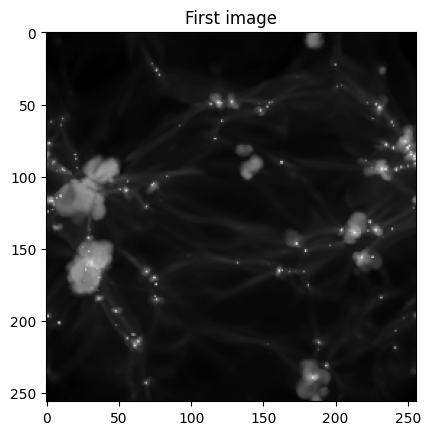

In [6]:
labelFile='params_1P_IllustrisTNG.txt'
firstFile='Maps_B_IllustrisTNG_1P_z=0.00.npy'

# Instantiate map object
bMap = Map(labelFile,firstFile)
# Log and normalize images
bMap.log_scale()
# Display some basic info
bMap.info()

resized_labels.shape : (990, 6) 

labels.shape : (165, 1)
images.shape : (165, 256, 256)
p_range : 11 

X_train.shape :  (131, 256, 256)
X_test.shape :  (17, 256, 256)
X_val.shape: (17, 256, 256)
y_train.shape : (131, 1)
y_test.shape : (17, 1)
y_val.shape : (17, 1) 



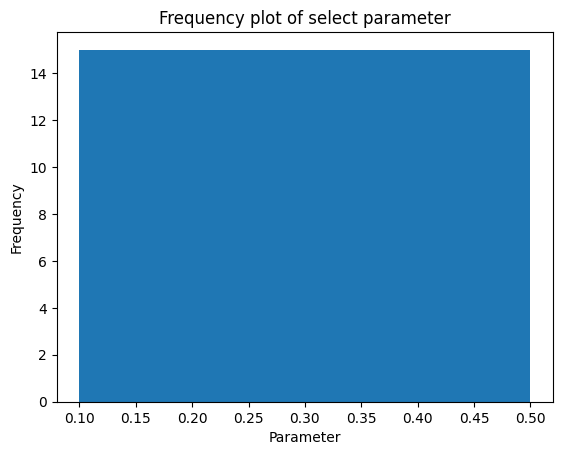

In [7]:
# Resize the labels array to match the images shape
resized_labels = bMap.resize(True)
# Create new labels for specific parameter we want to train on and predict
labels, images = bMap.extract_param(0, resized_labels) # omega_m parameter
# Check for a uniform distribution of values
bMap.plot_hist(labels)
# Split data ready for input into model
X_train, X_test, X_val, y_train, y_test, y_val = bMap.split_data(labels, images)

In [8]:
# Define a function to exponentially decrease learning rate
def scheduler(epoch, lr):
    '''Reduces learning rate exponentially after 20 epochs'''
    if epoch < 40:
        return lr
    else:
        return lr * np.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler) # callback parameter for .fit

In [ ]:
model.compile(optimizer='adamw', loss='huber', metrics=['mae']) # Compile with AdamW optimizer and Huber loss
history = model.fit(X_train, y_train, epochs=50, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val)) # train with lr scheduling

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - loss: 3.3618 - mae: 3.8293 - val_loss: 0.0493 - val_mae: 0.2845 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - loss: 2.1333 - mae: 2.5986 - val_loss: 0.0767 - val_mae: 0.3686 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - loss: 1.3282 - mae: 1.7446 - val_loss: 5.3034 - val_mae: 5.8034 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - loss: 1.5703 - mae: 2.0226 - val_loss: 0.4185 - val_mae: 0.9062 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - loss: 1.0732 - mae: 1.4965 - val_loss: 1.1619 - val_mae: 1.6619 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - loss: 0.7721 - mae: 1.1730 - val_loss: 0.0384 - val_mae: 0.2431 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - loss: 0.5457 - mae: 0.9269 - val_loss: 0.7925 - val_mae: 1.2925 - learning_rate: 0.0010
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0073 - mae: 0.0998
MAE Loss - Test Loss: 0.007315675262361765, Test MAE: 0.09984378516674042



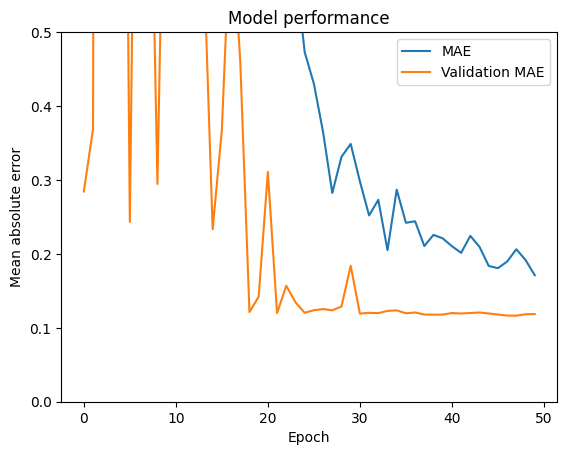

In [ ]:
test_loss, test_mae = eval_test(model, X_test, y_test, history)

## Scaling Model Complexity

In [10]:
# Model parameters
input_shape = (256, 256, 1)
H = 16
C = 1
DR = 0.2

model = paper_model(input_shape, H, C, DR)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_20 (LeakyReLU)           │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_21 (LeakyReLU)           │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 128, 128, 32)        │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 64, 64, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64, 64, 128)         │             5

 Total params: 60,346,433 (230.20 MB)

 Trainable params: 60,330,305 (230.14 MB)

 Non-trainable params: 16,128 (63.00 KB)

In [16]:
model.compile(optimizer='adamw', loss='huber', metrics=['mae']) # Compile with AdamW optimizer and Huber loss
history = model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[callback], validation_data=(X_val, y_val)) # train with lr scheduling

# Save data
np.save(Map.path+'/paper_history.npy', history)
model.save(Map.path+'paper_model.keras')

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.3091 - mae: 0.5912 - val_loss: 0.1035 - val_mae: 0.4321 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.1798 - mae: 0.4392 - val_loss: 15.3854 - val_mae: 15.8337 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.2414 - mae: 0.5389 - val_loss: 1.6268 - val_mae: 2.0608 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.1577 - mae: 0.4027 - val_loss: 0.0466 - val_mae: 0.2545 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.2409 - mae: 0.5429 - val_loss: 0.2867 - val_mae: 0.7525 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0896 - mae: 0.3260 - val_loss: 0.0110 - val_mae: 0.1296 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0748 - mae: 0.2926 - val_loss: 2.3607 - val_mae: 2.8368 - learning_rate: 0.0010
Epoch 8/100
9

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.0010 - mae: 0.0327
MAE Loss - Test Loss: 0.0010459412587806582, Test MAE: 0.03265860304236412



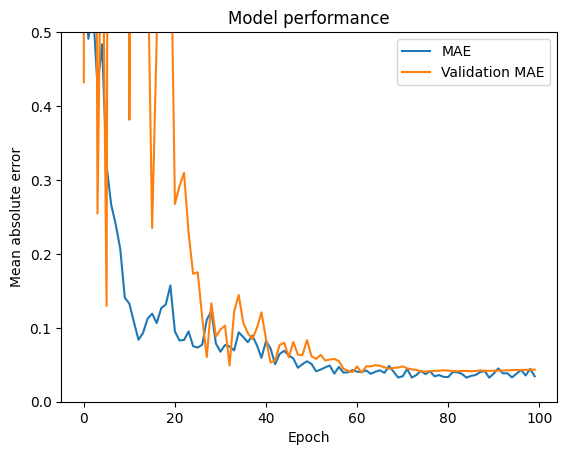

In [17]:
test_loss, test_mae = eval_test(model, X_test, y_test, history)

Conclusion: Model seems to max out at MAE of ~0.03, we require more training data to improve the model.